In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
import xrft
import gcsfs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dsmon = xr.open_zarr(gcsfs.GCSMap('pangeo-data/takaya/MITgcm-channel-flatbottom-02km-run01/phys-mon/'), consolidated=True)
dsmon

_call out of retries on exception: HTTPConnectionPool(host='metadata.google.internal', port=80): Max retries exceeded with url: /computeMetadata/v1/instance/service-accounts/default/?recursive=true (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f77466bf5f8>: Failed to establish a new connection: [Errno -2] Name or service not known',))
Traceback (most recent call last):
  File "/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/urllib3/connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/urllib3/util/connection.py", line 56, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/home/takaya/miniconda3/envs/uptodate/lib/python3.6/socket.py", line 745, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -2] Name o

<xarray.Dataset>
Dimensions:   (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 12)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    PHrefC    (Z) float32 dask.array<shape=(76,), chunksize=(76,)>
    PHrefF    (Zp1) float32 dask.array<shape=(77,), chunksize=(77,)>
  * XC        (XC) float32 1000.0 3000.0 5000.0 ... 995000.0 997000.0 999000.0
  * XG        (XG) float32 0.0 2000.0 4000.0 ... 994000.0 996000.0 998000.0
  * YC        (YC) float32 1000.0 3000.0 5000.0 ... 1997000.0 1999000.0
  * YG        (YG) float32 0.0 2000.0 4000.0 ... 1994000.0 1996000.0 1998000.0
  * Z         (Z) float32 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * Zl        (Zl) float32 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
  * Zp1       (Zp1) float32 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu        (Zu) float32 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
    drC       (Zp1) float64 dask.a

In [3]:
ds15d = xr.open_zarr(gcsfs.GCSMap('pangeo-data/takaya/MITgcm-channel-flatbottom-02km-run01/phys-snap15D'), 
                     consolidated=True)
ds15d

<xarray.Dataset>
Dimensions:  (XC: 500, XG: 500, YC: 1000, YG: 1000, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 25)
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
    PHrefC   (Z) float32 dask.array<shape=(76,), chunksize=(76,)>
    PHrefF   (Zp1) float32 dask.array<shape=(77,), chunksize=(77,)>
  * XC       (XC) float32 1000.0 3000.0 5000.0 ... 995000.0 997000.0 999000.0
  * XG       (XG) float32 0.0 2000.0 4000.0 ... 994000.0 996000.0 998000.0
  * YC       (YC) float32 1000.0 3000.0 5000.0 ... 1995000.0 1997000.0 1999000.0
  * YG       (YG) float32 0.0 2000.0 4000.0 ... 1994000.0 1996000.0 1998000.0
  * Z        (Z) float32 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * Zl       (Zl) float32 0.0 -1.0 -2.14 -3.44 ... -2562.59 -2689.32 -2825.33
  * Zp1      (Zp1) float32 0.0 -1.0 -2.14 -3.44 ... -2689.32 -2825.33 -3000.0
  * Zu       (Zu) float32 -1.0 -2.14 -3.44 -4.93 ... -2689.32 -2825.33 -3000.0
    drC      (Zp1) float64 dask.arra

# Surface temperature field

**Data starts from July 1**

In [7]:
date = 4

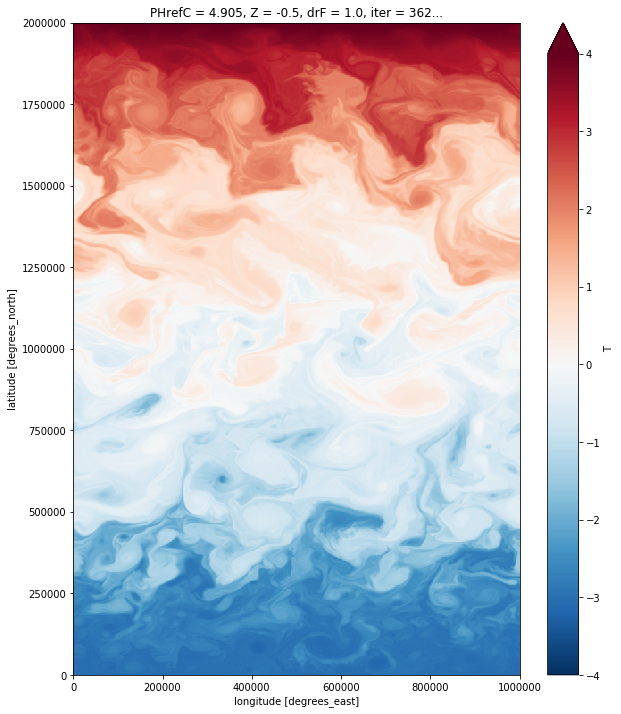

In [8]:
(ds15d['T'][date,0]-ds15d['T'][date,0].mean()).plot(figsize=(10,12), vmax=4.)

# Relative vorticity ($\zeta$)

In [9]:
grid = Grid(ds15d, periodic=['X'])

In [10]:
vx = grid.diff(ds15d.V*ds15d.dyC,'X') / ds15d.rAz
uy = grid.diff(ds15d.U*ds15d.dxC,'Y',boundary='fill') / ds15d.rAz

print(uy.coords, vx.coords)
with ProgressBar():
    zeta = (vx-uy)[date,0].compute()
zeta

Coordinates:
  * time     (time) timedelta64[ns] 1620 days 1635 days ... 1965 days 1980 days
  * Z        (Z) float32 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * YG       (YG) float32 0.0 2000.0 4000.0 ... 1994000.0 1996000.0 1998000.0
  * XG       (XG) float32 0.0 2000.0 4000.0 ... 994000.0 996000.0 998000.0
    rAz      (YG, XG) float32 dask.array<shape=(1000, 500), chunksize=(1000, 500)> Coordinates:
  * time     (time) timedelta64[ns] 1620 days 1635 days ... 1965 days 1980 days
  * Z        (Z) float32 -0.5 -1.57 -2.79 ... -2625.955 -2757.325 -2912.665
  * YG       (YG) float32 0.0 2000.0 4000.0 ... 1994000.0 1996000.0 1998000.0
  * XG       (XG) float32 0.0 2000.0 4000.0 ... 994000.0 996000.0 998000.0
    rAz      (YG, XG) float32 dask.array<shape=(1000, 500), chunksize=(1000, 500)>
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  4.4s


<xarray.DataArray (YG: 1000, XG: 500)>
array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [-2.569711e-05, -2.620642e-05, -2.501459e-05, ..., -1.856887e-05,
        -2.203370e-05, -2.405237e-05],
       [-7.543854e-06, -8.235908e-06, -9.218601e-06, ..., -1.234840e-05,
        -9.889415e-06, -8.063937e-06],
       ...,
       [-5.965806e-06, -6.756027e-06, -7.153470e-06, ..., -4.874917e-06,
        -5.278517e-06, -5.444112e-06],
       [-9.086998e-06, -7.468149e-06, -6.373464e-06, ..., -1.791837e-05,
        -1.347264e-05, -1.132827e-05],
       [-3.594031e-05, -3.301660e-05, -2.996502e-05, ..., -4.376580e-05,
        -4.085671e-05, -3.825126e-05]], dtype=float32)
Coordinates:
    time     timedelta64[ns] 1680 days
    Z        float32 -0.5
  * YG       (YG) float32 0.0 2000.0 4000.0 ... 1994000.0 1996000.0 1998000.0
  * XG       (XG) float32 0.0 2000.0 4000.0 ... 994000.0 996000.0 998000.0
    rAz      (YG, XG) float32 

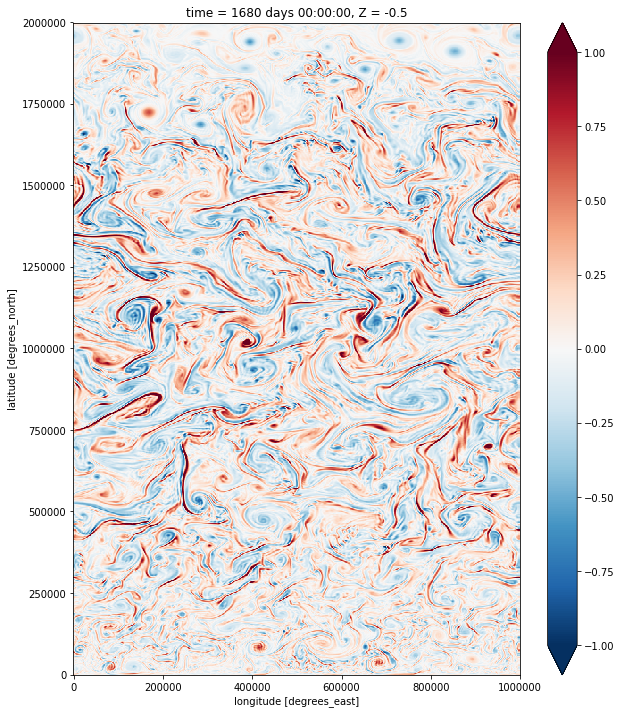

In [11]:
f0 = -1.1e-4
beta = 1.4e-11
cori = f0 + beta*(ds15d.YG-1e6)
(zeta/cori).plot(figsize=(10,12), vmax=1., vmin=-1., cmap='RdBu_r')

# KE zonal wavenumber spectra

In [12]:
dsmon.coords['seas'] = ('time',np.repeat(np.roll(range(4),-2),3))
ds15d.coords['seas'] = ('time',np.append(np.repeat(np.roll(range(4),-2),6),1))
dmsea = dsmon.groupby('seas').mean(['time','XC','XG'])

up = (ds15d.U.groupby('seas') - dmsea.uVeltave)
vp = (ds15d.V.groupby('seas') - dmsea.vVeltave)

In [ ]:
uk2 = xrft.power_spectrum(grid.interp(up,'X').sel(YC=slice(6e5,14e5)).chunk(chunks={'XC':500}),
                         dim=['XC'], detrend='constant')
vk2 = xrft.power_spectrum(grid.interp(vp,'Y',boundary='fill').sel(YC=slice(6e5,14e5)
                                                                 ).chunk(chunks={'XC':500}),
                         dim=['XC'], detrend='constant')

with ProgressBar():
    kek = (uk2 + vk2).compute()
kek.coords['seas'] = ('time',np.append(np.repeat(np.roll(range(4),-2),6),1))
kek

[########################################] | 100% Completed |  2min 44.6s


<xarray.DataArray (time: 25, Z: 76, YC: 400, freq_XC: 500)>
array([[[[7.717813e-04, ..., 3.078327e-03],
         ...,
         [2.300303e-05, ..., 1.391780e-03]],

        ...,

        [[1.197815e-07, ..., 3.223660e-08],
         ...,
         [1.767150e-05, ..., 5.537774e-06]]],


       ...,


       [[[3.518967e-04, ..., 2.474309e-04],
         ...,
         [6.215251e-05, ..., 2.554928e-05]],

        ...,

        [[1.857271e-07, ..., 6.999808e-06],
         ...,
         [2.121925e-06, ..., 5.564987e-08]]]])
Coordinates:
  * time             (time) timedelta64[ns] 1620 days 1635 days ... 1980 days
  * Z                (Z) float32 -0.5 -1.57 -2.79 ... -2757.325 -2912.665
  * YC               (YC) float32 601000.0 603000.0 ... 1397000.0 1399000.0
  * freq_XC          (freq_XC) float64 -0.00025 -0.000249 ... 0.000248 0.000249
    freq_XC_spacing  float64 1e-06
    seas             (time) int64 2 2 2 2 2 2 3 3 3 3 3 ... 0 0 0 1 1 1 1 1 1 1

In [ ]:
kek_seas = kek.groupby('seas').mean('time')
import matplotlib.ticker as tick

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()
ax3 = ax.twiny()
ax.plot(kek_seas.freq_XC[251:]*1e3, kek_seas[2,0,:,251:].mean(['YC']), 'b')
ax.plot(kek_seas.freq_XC[251:]*1e3, kek_seas[0,0,:,251:].mean(['YC']), 'r')
im, = ax2.plot(kek_seas.freq_XC[251:]*1e3, (kek_seas[2,0,:,251:]
                                            /kek_seas[0,0,:,251:]).mean(['YC']), 
              'g')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3,2.5e-1])
ax.set_xticks([1e-3,1e-2,1e-1])
ax.set_xticklabels([1e-3,1e-2,1e-1], fontsize=12)
ax.set_ylim([4e-4,4e4])
ax.set_yticks([1e-3,1e-1,1e1,1e3])
ax.set_yticklabels([1e-3,1e-1,1e1,1e3], fontsize=12)
ax.get_xaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax.get_yaxis().set_major_formatter(tick.LogFormatterSciNotation())
ax2.set_ylim([0.8,5.])
ax2.set_yticks([1.,2,3.,4,5.])
ax2.set_yticklabels([1.,2.,3.,4.,5.], fontsize=14)
ax2.spines["right"].set_edgecolor(im.get_color())
ax2.yaxis.label.set_color(im.get_color())
ax2.tick_params(axis='y', colors=im.get_color())
ax3.set_xscale('log')
ax3.set_xlim([1e-3,2.5e-1])
ax3.set_xticks([1e-3,1e-2,1e-1])
ax3.set_xticklabels(np.asarray([1e3,1e2,1e1], dtype=int), fontsize=12)
ax.set_xlabel(r'k [cpkm]', fontsize=14)
ax.set_ylabel(r'[m$^3$ s$^{-2}$]', fontsize=14)
ax2.set_ylabel(r'JAS/JFM', fontsize=14)
ax3.set_xlabel(r'[km]', fontsize=14)

Text(0.5, 0, '[km]')